### Cargar datos de MNIST

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

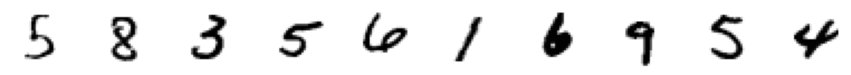

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# imprimimos 10 numeros aleatorios de MNIST
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')  
    ax.imshow(img, cmap='gray_r')

<img src="https://www.researchgate.net/profile/Xifeng_Guo/publication/320658590/figure/fig1/AS:614154637418504@1523437284408/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png" />

imagen de ejemplo tomada de <a href="https://www.researchgate.net/publication/320658590_Deep_Clustering_with_Convolutional_Autoencoders">Guo, et al (2017)</a>

### Encoder

In [3]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import numpy as np

- filter: numero de filtros de salida en la convolucion.
- kernel_size: tamano de la ventana a utilizar (3x3)
- strides: tamano del paso de la ventana (kernel_size)
- padding: con stride 1, el tamano de la salida es igual a la entrada de la capa.

In [4]:
# capa de entrada
encoder_input = Input(shape=(28,28,1), name='encoder_input')
x = encoder_input

# capas convolucionales
# ============= 1 =================
conv_layer = Conv2D(filters = 32 ,kernel_size = 3 , strides = 1, padding = 'same',
                    name = 'encoder_conv_1')
x = conv_layer(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.25)(x)

# ============= 2 =================
conv_layer = Conv2D(filters = 64 ,kernel_size = 3 , strides = 2, padding = 'same',
                    name = 'encoder_conv_2')
x = conv_layer(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.25)(x)

# ============= 3 =================
conv_layer = Conv2D(filters = 64 ,kernel_size = 3 , strides = 2, padding = 'same',
                    name = 'encoder_conv_3')
x = conv_layer(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.25)(x)

# ============= 4 =================
conv_layer = Conv2D(filters = 64 ,kernel_size = 3 , strides = 1, padding = 'same',
                    name = 'encoder_conv_4')
x = conv_layer(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.25)(x)

# Forma Convs
shape_before_flattening = K.int_shape(x)[1:]

# red neuronal (Flattening)
x = Flatten()(x)
encoder_output= Dense(2, name='encoder_output')(x)

# Modelo del ENCODER
ENCODER = Model(encoder_input, encoder_output)

ENCODER.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)       

### Decoder

In [5]:
# la capa de entrada tiene las dimensiones de la capa de salida
# del encoder_output (2)
decoder_input = Input(shape=(2,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

# capas convolucionales (vamos a la inversa)
# la misma cosa que el encoder, pero al reves
# ============= 4 =================
conv_t_layer = Conv2DTranspose(filters = 64 ,kernel_size = 3 , strides = 1, padding = 'same',
                    name = 'decoder_conv_4')
x = conv_t_layer(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.25)(x)

# ============= 3 =================
conv_t_layer = Conv2DTranspose(filters = 64 ,kernel_size = 3 , strides = 2, padding = 'same',
                    name = 'decoder_conv_3')
x = conv_t_layer(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.25)(x)

# ============= 2 =================
conv_t_layer = Conv2DTranspose(filters = 32 ,kernel_size = 3 , strides = 2, padding = 'same',
                    name = 'decoder_conv_2')
x = conv_t_layer(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate = 0.25)(x)

# ============= 1 =================
conv_t_layer = Conv2DTranspose(filters = 1 ,kernel_size = 3 , strides = 1, padding = 'same',
                    name = 'decoder_conv_1')
x = conv_t_layer(x)
x = Activation('sigmoid')(x)

# Salida
decoder_output = x
# Model del DECODER
DECODER = Model(decoder_input, decoder_output)

DECODER.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_4 (Conv2DTransp (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)         

### El AutoEncoder

In [6]:
# union de encoder y decoder
model_input = encoder_input
model_output = DECODER(encoder_output)

# modelo del autoencoder
model = Model(model_input, model_output)

### Compilar el Modelo

In [7]:
learning_rate = 0.0005
batch_size = 32

optimizer = Adam(lr=learning_rate)

# RMSE
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

model.compile(optimizer=optimizer, loss = r_loss)

### Iniciar Entrenamiento

In [8]:
# ejecutar el entrenamiento
model.fit(  x = x_train[:1000]
            ,y = x_train[:1000]
            , batch_size = batch_size
            , shuffle = True
            , epochs = 200
            , initial_epoch = 0
        )

Epoch 1/200
32/32 [==============================] - 3s 86ms/step - loss: 0.1772
Epoch 2/200
32/32 [==============================] - 3s 88ms/step - loss: 0.1065
Epoch 3/200
32/32 [==============================] - 2s 77ms/step - loss: 0.0971
Epoch 4/200
32/32 [==============================] - 2s 77ms/step - loss: 0.0914
Epoch 5/200
32/32 [==============================] - 3s 82ms/step - loss: 0.0869
Epoch 6/200
32/32 [==============================] - 3s 78ms/step - loss: 0.0821
Epoch 7/200
32/32 [==============================] - 3s 84ms/step - loss: 0.0792
Epoch 8/200
32/32 [==============================] - 3s 81ms/step - loss: 0.0761
Epoch 9/200
32/32 [==============================] - 3s 82ms/step - loss: 0.0747
Epoch 10/200
32/32 [==============================] - 3s 84ms/step - loss: 0.0729
Epoch 11/200
32/32 [==============================] - 3s 83ms/step - loss: 0.0723
Epoch 12/200
32/32 [==============================] - 3s 82ms/step - loss: 0.0689
Epoch 13/200
32/32 [=====

32/32 [==============================] - 3s 99ms/step - loss: 0.0487
Epoch 101/200
32/32 [==============================] - 3s 93ms/step - loss: 0.0485
Epoch 102/200
32/32 [==============================] - 4s 113ms/step - loss: 0.0485
Epoch 103/200
32/32 [==============================] - 4s 114ms/step - loss: 0.0483
Epoch 104/200
32/32 [==============================] - 4s 113ms/step - loss: 0.0484
Epoch 105/200
32/32 [==============================] - 4s 118ms/step - loss: 0.0484
Epoch 106/200
32/32 [==============================] - 3s 84ms/step - loss: 0.0483
Epoch 107/200
32/32 [==============================] - 3s 82ms/step - loss: 0.0486
Epoch 108/200
32/32 [==============================] - 3s 80ms/step - loss: 0.0483
Epoch 109/200
32/32 [==============================] - 3s 82ms/step - loss: 0.0481
Epoch 110/200
32/32 [==============================] - 3s 79ms/step - loss: 0.0485
Epoch 111/200
32/32 [==============================] - 3s 80ms/step - loss: 0.0481
Epoch 112/200


32/32 [==============================] - 3s 80ms/step - loss: 0.0449
Epoch 199/200
32/32 [==============================] - 2s 74ms/step - loss: 0.0449
Epoch 200/200
32/32 [==============================] - 2s 74ms/step - loss: 0.0447


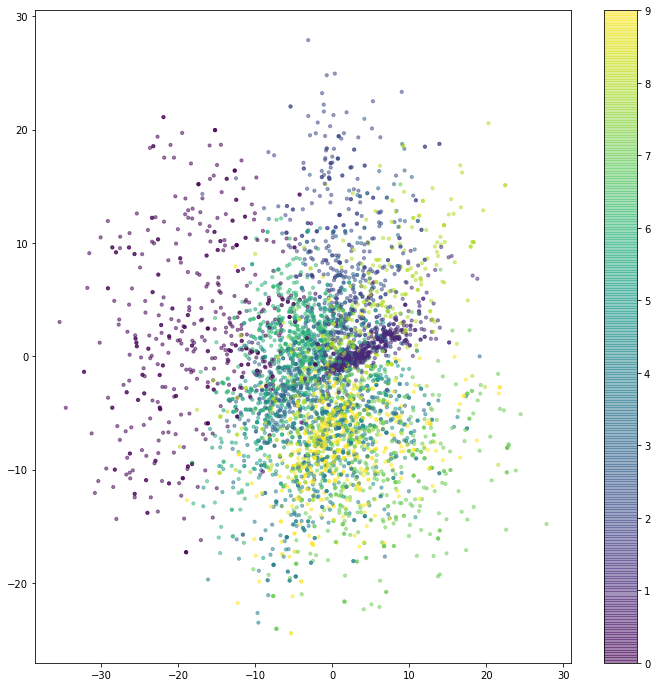

In [9]:
# desplegar 5000 imagenes DECODER(5000) -> x,y (z_points)

n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = ENCODER.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c=example_labels, alpha=0.5, s=10)
plt.colorbar()
plt.show()

In [10]:
n_to_show = 10

# Seleccionar 10 imagenes aleatorias de x_test
example_idx_10 = np.random.choice(range(len(x_test)), n_to_show)
example_images_10 = x_test[example_idx_10]

# Codifique 
z_points_10 = ENCODER.predict(example_images_10)

# Decodifique
reconst_images = DECODER.predict(z_points_10)

print(z_points)

[[ 13.95475    -19.249142  ]
 [-13.899483     0.55332375]
 [  0.5614038   -1.6072025 ]
 ...
 [  1.7368267  -13.85111   ]
 [  1.9493704   -0.29541415]
 [  5.259431    -6.46937   ]]


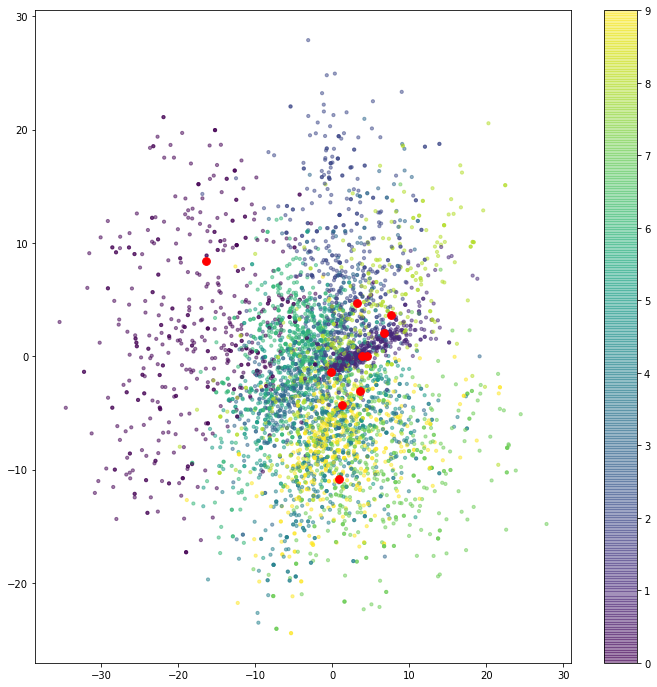

In [11]:
plt.figure(figsize=(figsize, figsize))
# visualiza 5000 puntos de x_test
plt.scatter(z_points[:, 0] , z_points[:, 1], c=example_labels, alpha=0.5, s=10)
plt.colorbar()
# imprime puntos rojos (ENCODED)
plt.scatter(z_points_10[:, 0] , z_points_10[:, 1], c = 'red', alpha=1, s=60)
plt.show()

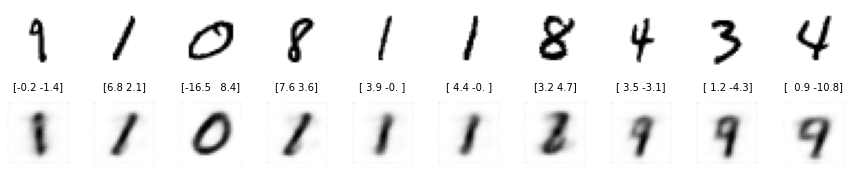

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Imagenes de Ejemplo
for i in range(n_to_show):
    img = example_images_10[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points_10[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

# Imagenes Reconstruidas
for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')